# 8.B: Support vector machines (SVMs)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
from sklearn import datasets

import mylib as my
import cvxopt as cvxopt

With support vector machines we are using linear models. Here we are looking for separating lines/planes/hyperplanes with maximum margins. These best separators are modeled by the linear equation:

$$\mathbf{w}^T \mathbf{x} + b = 0$$

Notice how purposely moved the bias term $b$ outside of the weight vector $\mathbf{w}$. Here we seek the separator with the maximum (thickest) margins.

## Hard-margin SVMs

First we look into separating a linearly-separable dataset. Below is the dual optimization problem we need to solve:

**Minimize**: 
  $$
    \mathcal{L}(\mathbf{\alpha}) = \sum_{i = 1}^N \alpha_i - \frac{1}{2} \sum_{i = 1}^N \sum_{j = 1}^N \alpha_i \alpha_j y_i y_j \mathbf{x}_i \mathbf{x}_j
  $$

**Subject to**:
  $$
    \left\{  \begin{array}{ll}
      \sum_{i = 1}^N \alpha_i y_i = 0 & \text{ and }\\ 
      \alpha_i  \geq 0 &  \text{ for all points } i = 1, 2, \cdots, N 
    \end{array}\right.
  $$

  This is a quadratic problem that can be passed to an off-the-shelf quadratic problem solver to obtain the values of Lagrange multipliers $\alpha_i$.

Here is a simple implementation of a this hard-margin SVM classifier. This implementation uses the `SLSQP` solver of [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to solve the above optimization problem. Notice how the constraints are implemented using the `constraints` argument object.

In [10]:
class HardSVM:
    def __init__(self, dataset, threshold=1e-5):
        self.threshold = threshold
        self.ds = dataset
        self.alpha = None
        self.w = None
        self.b = None
    
    def lagrange(self, G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
        
    def lagrange_derivative(self, G, alpha):
        return np.ones_like(alpha) - alpha.dot(G)
    
    def fit(self):
        X, y = self.ds.inputs, self.ds.target.astype('float').flatten()
        N = len(X)
        
        Xy = X * y[:, np.newaxis]
        G = np.matmul(Xy, Xy.T)

        # Calling the quadratic solver
        results = scipy.optimize.minimize(
            fun=lambda a: -self.lagrange(G, a),
            x0=np.ones(N), 
            method='SLSQP', 
            jac=lambda a: -self.lagrange_derivative(G, a), 
            constraints=(
               {'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
               {'type': 'ineq', 'fun': lambda a: np.dot(np.eye(N), a), 'jac': lambda a: np.eye(N)}
            ))
        
        self.alpha = results.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)
        
        # The support vectors and their output
        self.sv_x = X[self.alpha > self.threshold]
        self.sv_y = y[self.alpha > self.threshold]
        
        # The intercept
        self.b = self.sv_y[0] - np.matmul(self.sv_x[0].T, self.w)
    
    def predict(self, unseen):
        return 2 * ((np.matmul(unseen, self.w) + self.b) > 0) - 1

Let's test this on our familiar AND and OR logical functions, both of which are linearly separable. We'll also see how it does on the linearly inseparable XOR function. We'll start by defining a function for plotting the margin street and highlight the support vectors.

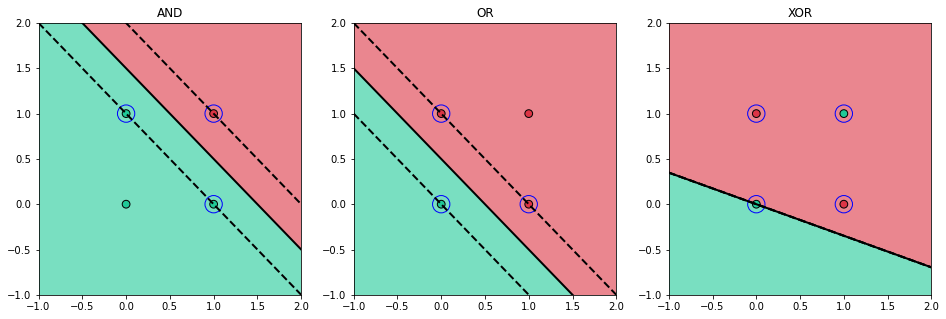

In [11]:
def plotSVM(svm, xmin, xmax, ax):
    w = svm.w
    b = svm.b

    x0 = np.linspace(xmin, xmax, 100)
    separator = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_above = separator + margin
    gutter_below = separator - margin

    svx = svm.sv_x
    ax.scatter(svx[:,0], svx[:,1], s=300, facecolors='none', edgecolors='b', color='b')
    ax.plot(x0, separator, "k-", linewidth=2)
    ax.plot(x0, gutter_above, "k--", linewidth=2)
    ax.plot(x0, gutter_below, "k--", linewidth=2)

    
fig = plt.figure(figsize=(16,5))
data = [
    pd.DataFrame(np.array([[0,0,-1],[0,1,-1],[1,0,-1],[1,1,1]]), columns=['x1', 'x2', 'y']), # AND
    pd.DataFrame(np.array([[0,0,-1],[0,1,1],[1,0,1],[1,1,1]]), columns=['x1', 'x2', 'y']), # OR
    pd.DataFrame(np.array([[0,0,-1],[0,1,1],[1,0,1],[1,1,-1]]), columns=['x1', 'x2', 'y'])  # XOR
]
titles = ['AND', 'OR', 'XOR']

axes = fig.subplots(1,3)
for i in range(len(data)):
    ds = my.DataSet(data[i])
    svm = HardSVM(ds)
    svm.fit()
    axes[i].scatter(ds.inputs[:, 0], ds.inputs[:, 1], s=180, facecolors='blue')

    my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.01, ax=axes[i])
    axes[i].set_title(titles[i])
    plotSVM(svm, -1, 2, axes[i])
    axes[i].set_xlim(-1, 2)
    axes[i].set_ylim(-1, 2)

As you can see, the decision boundaries have nice margins. See how it fails in the case of XOR where the data is linearly inseparable. Can you identify the support vectors in these plots?

Here is another example using the iris dataset. For visualization purposes, only two features are being used, and for the implementation above to work, we had to reduce the classes from 3 to 2 (setosa vs. everything else). This is because SVM is binary classifier. The support vector points are marked with marked with blue circles around them.

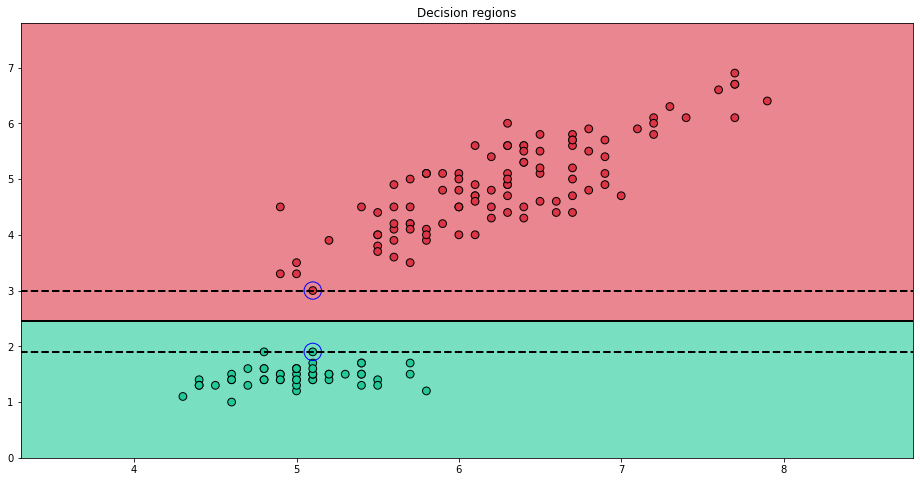

In [12]:
# Prepping the data
df = sns.load_dataset("iris")
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: -1 if x == 'setosa' else 1)
ds = my.DataSet(df.iloc[:, [0,2,4]], y=True)

# Fitting the model
svm = HardSVM(ds)
svm.fit()

# Plotting
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)
my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.1,ax=ax)
plotSVM(svm, 0, 9, ax)

## Soft-margin SVMs
We now look into the case where the data is not not linearly separable. In this case we use slack variables to allow for errors and we also use a hyperparameter named $C$ to balance between the size of the margin and the number of violations. The dual optimization problem we'll need to solve. 

**Minimize**: 
  $$
    \mathcal{L}(\mathbf{\alpha}) = \sum_{i = 1}^N \alpha_i - \frac{1}{2} \sum_{i = 1}^N \sum_{j = 1}^N \alpha_i \alpha_j y_i y_j \mathbf{x}_i \mathbf{x}_j
  $$

**Subject to**:
  $$
    \left\{  \begin{array}{ll}
      \sum_{i = 1}^N \alpha_i y_i = 0 & \text{ and }\\ 
      C \geq \alpha_i  \geq 0 &  \text{ for all points } i = 1, 2, \cdots, N 
    \end{array}\right.
  $$

which is surprisingly the same as before except for the last constraint.

Here is a simple implementation of a this soft-margin SVM classifier. Notice again how the constraints are implemented using the `constraints` argument object.

In [13]:
class SoftSVM:
    def __init__(self, dataset, C=1, threshold=1e-5):
        self.ds = dataset
        self.threshold = threshold
        self.C = C
        self.alpha = None
        self.w = None
        self.b = None
    
    def lagrange(self, G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
        
    def lagrange_derivative(self, G, alpha):
        return np.ones_like(alpha) - alpha.dot(G)
    
    def fit(self):
        X, y = self.ds.inputs, self.ds.target.astype('float').flatten()
        N = len(X)
        Xy = X * y[:, np.newaxis]
        G = np.matmul(Xy, Xy.T)

        # Calling the quadratic solver
        results = scipy.optimize.minimize(
            fun=lambda a: -self.lagrange(G, a),
            x0=np.ones(N), 
            method='SLSQP', 
            jac=lambda a: -self.lagrange_derivative(G, a), 
            constraints=(
                {'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                {'type': 'ineq', 'fun': lambda a: np.dot(np.eye(N), a), 'jac': lambda a: np.eye(N)},
                {'type': 'ineq', 'fun': lambda a: self.C - np.dot(np.eye(N), a), 'jac': lambda a: -np.eye(N)}
            ))
        
        self.alpha = results.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)
        
        # The support vectors and their output
        self.sv_x = X[self.alpha > self.threshold]
        self.sv_y = y[self.alpha > self.threshold]
        
        # The intercept
        self.b = self.sv_y[0] - np.matmul(self.sv_x[0].T, self.w)
    
    def predict(self, unseen):
        return 2 * ((np.matmul(unseen, self.w) + self.b) > 0) - 1

We'll use the iris dataset to test this model, but this time it is virginica flowrs against everything else. We'll do this using three different values of C: 1, 10, 100. We'll zoom in and focus on the margin.

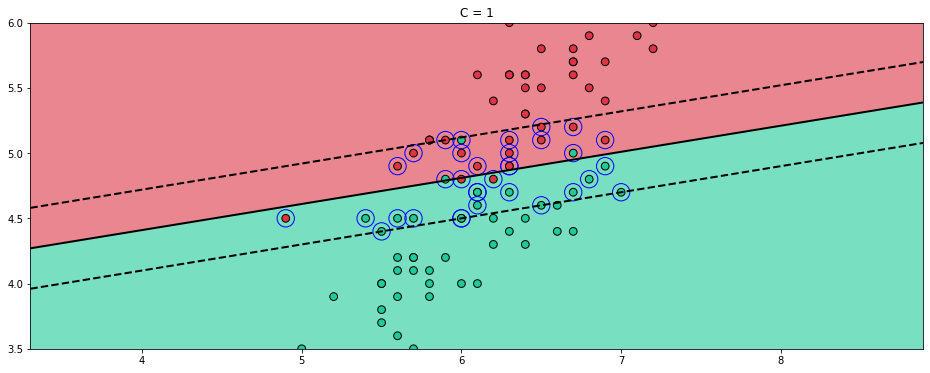

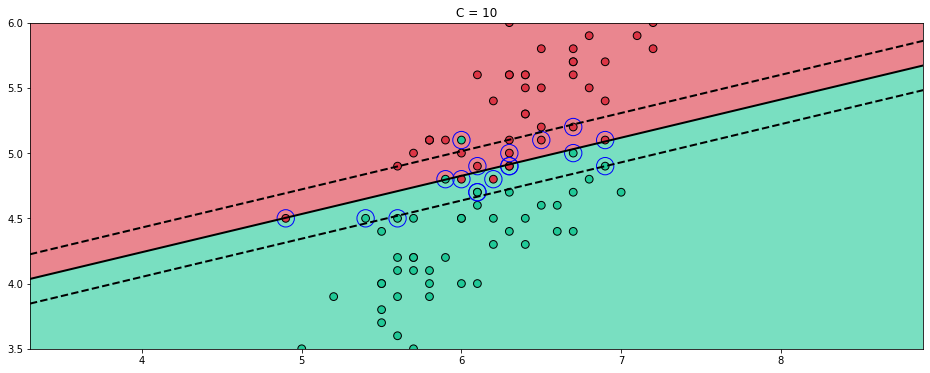

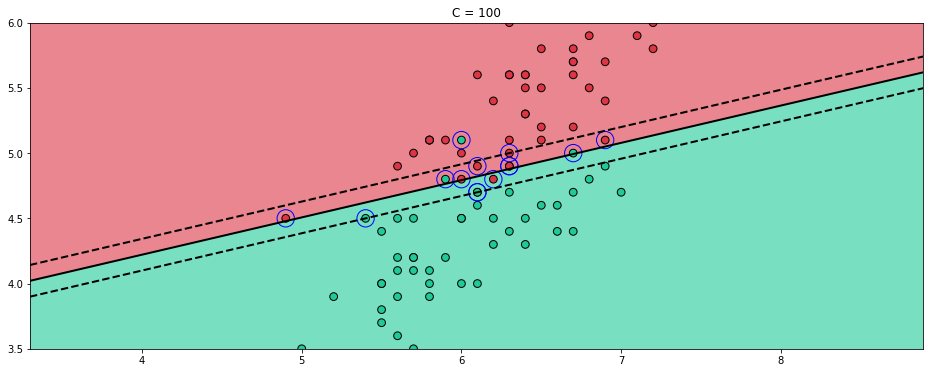

In [14]:
# Prepping the data
df = sns.load_dataset("iris")
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x == 'virginica' else -1)
ds = my.DataSet(df.iloc[:, [0,2,4]], y=True)

# Fitting models and plotting
# C = 1
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1, 1)
svm = SoftSVM(ds, C=1)
svm.fit()
my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.01, ax=ax)
ax.set_title(f"C = 1")
ax.set_ylim(3.5, 6)
plotSVM(svm, 0, 9, ax)

# C = 10
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1, 1)
svm = SoftSVM(ds, C=10)
svm.fit()
my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.01, ax=ax)
ax.set_title(f"C = 10")
ax.set_ylim(3.5, 6)
plotSVM(svm, 0, 9, ax)

# C = 100
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1, 1)
svm = SoftSVM(ds, C=100)
svm.fit()
my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.01, ax=ax)
ax.set_title(f"C = 100")
ax.set_ylim(3.5, 6)
plotSVM(svm, 0, 9, ax)

As you can see large `C` values corresponds to smaller margins.

## Kernalized SVMs
Linearly inseparable data in some d-dimensional space can be separable in higher-dimensional space.Given an $m$-dimensional example $\mathbf{x} \in \mathbb{R}^m$, we can use a non-linear function: 
$$\phi: \mathbb{R}^m \rightarrow \mathbb{R}^k$$
  where $k > m$

The main idea here is to:
* use a function $\phi$ to transform $\mathbf{x}$ into a high-dimensional space where the data $\mathbf{X}$ is linearly separable.
* use the hard-margin SVM to classify the data in this high-dimensional space.

Doing this give the following Lagrangian:

  $$\mathcal{L_z}(\mathbf{\alpha}) =  \sum_{i = 1}^N \alpha_i - \frac{1}{2} \sum_{i = 1}^N \sum_{j = 1}^N \alpha_i \alpha_j y_i y_j \phi(\mathbf{x}_i) \phi(\mathbf{x}_j) $$

  Notice that Lagrangian $\mathcal{L_x}$ depends not on any $\mathbf{x}$ by itself, but on the dot product $\phi(\mathbf{x}_i)\phi(\mathbf{x}_j)$. Using the kernel trick we get the dual problem:
  
**Minimize**: 
$$\mathcal{L_z}(\mathbf{\alpha}) =  \sum_{i = 1}^N \alpha_i - \frac{1}{2} \sum_{i = 1}^N \sum_{j = 1}^N \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) $$


**Subject to**:
  $$
    \left\{  \begin{array}{ll}
      \sum_{i = 1}^N \alpha_i y_i = 0 & \text{ and }\\ 
      \alpha_i  \geq 0 &  \text{ for all points } i = 1, 2, \cdots, N 
    \end{array}\right.
  $$
  
Below is a simple implementation of this model. If a kernel function is not given, the RBF kernel defined as:

$$ K(\mathbf{x}_i, \mathbf{x}_j) = exp(-\gamma \Vert \mathbf{x}_i, \mathbf{x}_j \Vert) $$

is used.

In [15]:
class KernelizedSVM:
    
    def __init__(self, dataset, kernel=None, threshold=1e-5, gamma=5):
        self.ds = dataset
        self.threshold = threshold
        self.alpha = None
        self.kernel = kernel or (lambda x1, x2, gamma=gamma: np.exp(-gamma * np.linalg.norm(x1 - x2)))
        
    
    def lagrange(self, G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
        
    def lagrange_derivative(self, G, alpha):
        return np.ones_like(alpha) - alpha.dot(G)
    
    def fit(self):
        X, y = self.ds.inputs, self.ds.target.astype('float').flatten()
        N = len(X)
        
        Xy = X * y[:, np.newaxis]
        G = np.matmul(Xy, Xy.T)
        

        XX = np.apply_along_axis(
            lambda x1 : np.apply_along_axis(
                lambda x2:  self.kernel(x1, x2), 1, X
            ), 1, X)   
        yp = y.reshape(-1, 1)
        G = XX * np.matmul(yp, yp.T) 

        # Calling the quadratic solver
        results = scipy.optimize.minimize(
            fun=lambda a: -self.lagrange(G, a),
            x0=np.ones(N), 
            method='SLSQP', 
            jac=lambda a: -self.lagrange_derivative(G, a), 
            constraints=(
                {'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                {'type': 'ineq', 'fun': lambda a: np.dot(np.eye(N), a), 'jac': lambda a: np.eye(N)}
            ))
        
        
        self.alpha = results.x
        
        # The support vectors and their output
        self.sv_x = X[self.alpha > self.threshold]
        self.sv_y = y[self.alpha > self.threshold]
        self.alpha_y =self.sv_y * self.alpha[self.alpha > self.threshold]
        self.sv_N = len(self.sv_y)

        # The intercept
        def sum_i(i):
            def sum_j(j):
                return (self.kernel(self.sv_x[i], self.sv_x[j]) * self.alpha_y[j])
            
            return self.sv_y[i] - np.apply_along_axis(sum_j, 1, np.arange(self.sv_N).reshape(-1, 1)).sum()
        
        self.b = np.apply_along_axis(sum_i, 1, np.arange(self.sv_N).reshape(-1, 1)).sum() / self.sv_N

    def predict(self, unseen):
        def predict_one(x):
            def sum_i(i):
                return self.kernel(self.sv_x[i], x) * self.alpha_y[i]
            
            return np.apply_along_axis(sum_i, 1,  np.arange(self.sv_N).reshape(-1, 1)).sum()
        
        h = np.apply_along_axis(predict_one, 1, unseen) + self.b
        return 2 * (h > 0) - 1

Let's test this using the following linearly unseparable circular data:

Text(0.5, 1.0, 'Linearly inseparable')

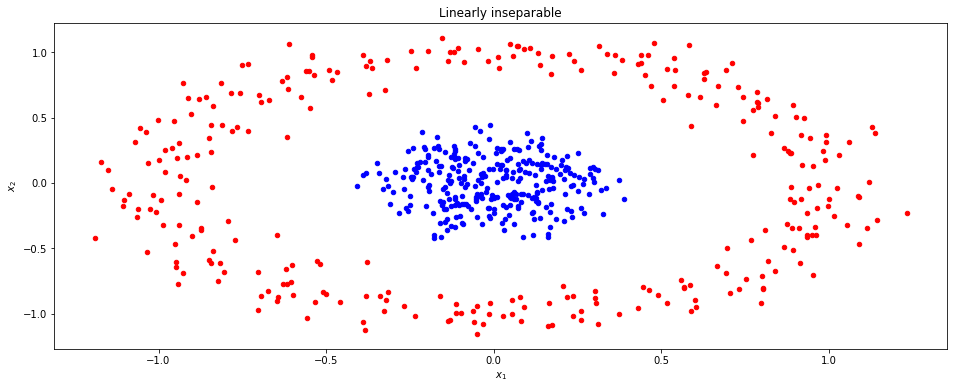

In [16]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=600, random_state=123, noise=0.1, factor=0.2)
reds = y == 0
blues = y == 1

fig = plt.figure(figsize=(16, 6))
ax1 = fig.subplots(1, 1)
ax1.scatter(X[reds, 0] , X[reds, 1], c="red",
            s=20)
ax1.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_title('Linearly inseparable')

Obviously, our hard- or soft-margin models are not going to work.  

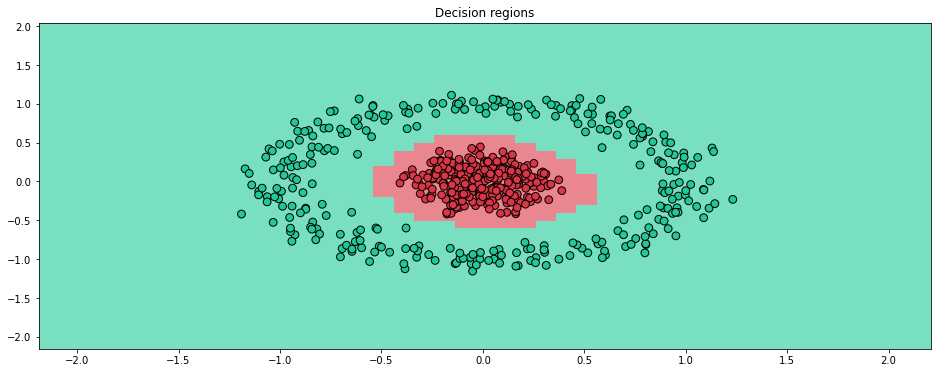

In [17]:
d = np.concatenate((X, y.reshape(len(y), 1)), axis=1)
ds = my.DataSet(pd.DataFrame(d, columns=['x1', 'x2', 'y']), y=True)
ds.examples.iloc[:, -1] = ds.examples.iloc[:, -1].apply(lambda x: -1 if x == 0 else 1)
svm = KernelizedSVM(ds, gamma=5)
svm.fit()

fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 1)
my.plot_decision_regions(ds.inputs, ds.target, svm, resolution=0.1, ax=ax)

As you can see, this takes a bit of time, which goes back to the fact that SVMs don't scale well to large data. The fact that the implementation above is about being simple rather than being efficient doesn't help either.

### CHALLENGE (Optional)
Given the moon-shaped data:

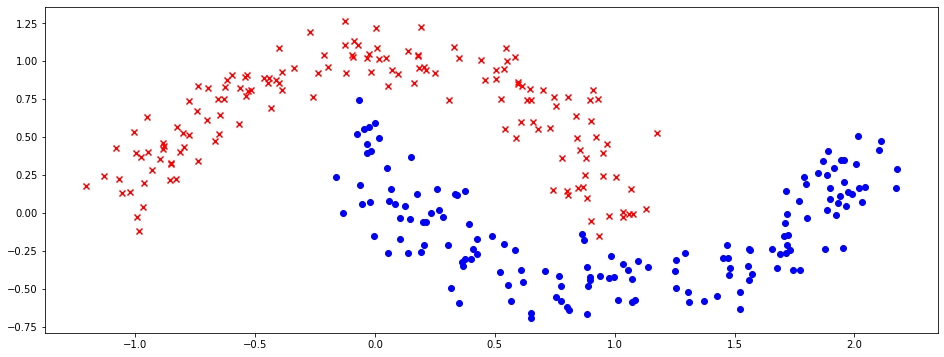

In [10]:
from sklearn.datasets import make_moons
fig = plt.figure(figsize=(16, 6))
X, y = make_moons(n_samples=300, random_state=17,noise=.1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='x')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o')

Create two kernel functions: 
* Polynomial with degree $d$ and coefficient $r$: 
$$\mathbf{K}(\mathbf{x}_i, \mathbf{x}_j) = \gamma(r + \mathbf{x}_i^T \mathbf{x}_j)^d$$ 
* Sigmoid with parameters $\gamma$ and $r$:
$$\mathbf{K}(\mathbf{x}_i, \mathbf{x}_j) = tanh(\gamma \mathbf{x}_i^T \mathbf{x}_j + r)$$

Fit three kernelized SVM models to the data above: one using the sigmoid kernel, another using the polynomial kernel, and a third using the already implemented RBB kernel. Play with the $\gamma$, $d$, and $r$ parameters to get the best fit you could.

In [11]:
# TODO